<a href="https://www.kaggle.com/code/ksenia5/london-tfl-bike-scheme-2017-geospatial-analysis?scriptVersionId=122093558" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Geospatial Data Visualisation of the London Public Bike Scheme

Data for 1.54 million bike journeys taken from over 700 bike stations of the Lonbon public bike scheme in the 50-day period between 1st August and 19th September 2017 ([data here](https://www.kaggle.com/datasets/edenau/london-bike-sharing-system-data)) is analysed and visualised using GeoPandas and Folium.

**The aim is to build an interactive map for visualising summary statistics for bike stations across London.**

The number of daily journeys started at each station is calculated, along with median and total journey duration. As station capacity differs across stations the mean daily journey count per station capacity is plotted for each station. The area within which the scheme operates is divided into regions (voronoi polygons) to show how journey count and duration varies with location.


## Import packages
Data visualisation libraries used included matplotlib, geopandas and folium. Geospatial data processing libraries include shapely, geovoronoi, scipy and numpy.

In [1]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime # to manually create dates 
import matplotlib.pyplot as plt
import math

# Geospatial libraries and modules
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
from shapely.ops import cascaded_union, unary_union, polygonize
import shapely.geometry as geometry
from shapely.geometry import Point, LineString, Polygon
!pip install geovoronoi
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import osmnx as ox
from scipy.spatial import Delaunay

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/kaggle/input/london-bike-sharing-system-data/journeys.csv
/kaggle/input/london-bike-sharing-system-data/stations.csv


In [2]:
# Read in data
journeys = pd.read_csv('/kaggle/input/london-bike-sharing-system-data/journeys.csv')
stations = pd.read_csv('/kaggle/input/london-bike-sharing-system-data/stations.csv')

# View data
print("Journeys data shape: ",journeys.shape)
display(journeys.head())
print("Stations data shape: ",stations.shape)
display(stations.head())

Journeys data shape:  (1542844, 14)


Journey Duration  Journey ID  End Date  End Month  End Year  End Hour  \
0            2040.0         953        19          9        17        18   
1            1800.0       12581        19          9        17        15   
2            1140.0        1159        15          9        17        17   
3             420.0        2375        14          9        17        12   
4            1200.0       14659        13          9        17        19   

   End Minute  End Station ID  Start Date  Start Month  Start Year  \
0           0             478          19            9          17   
1          21             122          19            9          17   
2           1             639          15            9          17   
3          16             755          14            9          17   
4          33             605          13            9          17   

   Start Hour  Start Minute  Start Station ID  
0          17            26               251  
1          14            51               550  
2          16            42               212  
3          12             9               163  
4          19            13                36

Stations data shape:  (773, 5)


Station ID  Capacity   Latitude  Longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           Station Name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square

Stations dataset contains 773 stations, their location, station name and capacity.

<br>

Journeys dataset contains data on 1.54 M journeys taken along with date and time the journeys were started, station ID, journey duration and end station ID, date and time.

In [3]:
# View summary statistics
display(stations.describe())

# Relabel columns
stations.columns = ['station_id', 'capacity', 'latitude', 'longitude','station_name']
stations.head()

Station ID    Capacity    Latitude   Longitude
count  773.000000  773.000000  773.000000  773.000000
mean   412.781371   26.725744   51.506017   -0.129055
std    240.381934    9.102031    0.020103    0.055362
min      1.000000   10.000000   51.454752   -0.236769
25%    203.000000   20.000000   51.493146   -0.173656
50%    411.000000   25.000000   51.509224   -0.131213
75%    625.000000   32.000000   51.520962   -0.092940
max    826.000000   64.000000   51.549369   -0.002275

station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square

Next, create a geodataframe from stations data. This allows to easily plot location data using geopandas geodataframe methods.

In [4]:
# Add a column 'location' with latitude and longitude converted to Point geometry
stations['geometry'] = stations.apply(lambda x: Point((x.longitude, x.latitude)), axis=1)

# Set the geodata projection
london_crs = 'epsg:27700'
location_crs = 'epsg:4326'

# Make a copy of stations data and convert to geodataframe
stations_gdf = stations.copy()
stations_gdf = gpd.GeoDataFrame(stations_gdf, crs = location_crs, geometry=stations.geometry)

# View the stations dataframe and geodataframe
display(stations.head())
display(stations_gdf.head())
display(type(stations))
display(type(stations_gdf))
stations_gdf.index

# Check crs of geodataframe
# stations_gdf.crs

/opt/conda/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name                     geometry  
0            River Street , Clerkenwell   POINT (-0.10997 51.529163)  
1        Phillimore Gardens, Kensington  POINT (-0.197574 51.499606)  
2  Christopher Street, Liverpool Street  POINT (-0.084605 51.521283)  
3       St. Chad's Street, King's Cross  POINT (-0.120973 51.530059)  
4         Sedding Street, Sloane Square   POINT (-0.156876 51.49313)

station_id  capacity   latitude  longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           station_name                   geometry  
0            River Street , Clerkenwell  POINT (-0.10997 51.52916)  
1        Phillimore Gardens, Kensington  POINT (-0.19757 51.49961)  
2  Christopher Street, Liverpool Street  POINT (-0.08460 51.52128)  
3       St. Chad's Street, King's Cross  POINT (-0.12097 51.53006)  
4         Sedding Street, Sloane Square  POINT (-0.15688 51.49313)

pandas.core.frame.DataFrame

geopandas.geodataframe.GeoDataFrame

RangeIndex(start=0, stop=773, step=1)

### Calculate journey statistics

- Count the number of journeys started at each station.
- Calcullate the total journey duration for journeys started at each station.
- Append statistics to the stations geodataframe.
- Calculate journey count/ capacity for each station.

In [5]:
# Calculate the total number of journeys and the mean journey count for each station
journey_counts = journeys.groupby(['Start Station ID']).size().to_frame()
journey_counts = journey_counts.reset_index()
journey_counts.columns = ['station_id', 'journey_count']

# Divide by 50 as the total number of journeys were taken over 50 days, round to 2 d.p.
journey_counts['daily_journey_count'] = np.round(journey_counts['journey_count']/50,2)
display(journey_counts.head())
journey_counts.shape

station_id  journey_count  daily_journey_count
0           1           1269                25.38
1           2           2055                41.10
2           3           3337                66.74
3           4           1405                28.10
4           5           3335                66.70

(779, 3)

In [6]:
# Calcuate total journey duration in hours (journey duration is originally in seconds, so divide by 60*60)
total_duration = journeys.groupby(['Start Station ID'])['Journey Duration'].sum()/(60*60)
total_duration = total_duration.to_frame().reset_index()
total_duration.columns = ['station_id', 'total_duration_hours']

# Calcuate median journey duration in minutes for each station
median_duration = np.round(journeys.groupby(['Start Station ID'])['Journey Duration'].median()/(60),1)
median_duration = median_duration.to_frame().reset_index()
median_duration.columns = ['station_id', 'median_duration_mins']

# journeys[journeys['Start Station ID'] == 2]['Journey Duration'].sum()
display(total_duration.head())
display(median_duration.head())
display(total_duration.shape)
display(median_duration.shape)
display(type(total_duration))
display(type(median_duration))

station_id  total_duration_hours
0           1            338.154444
1           2            712.716667
2           3            834.736944
3           4            456.862500
4           5           1043.140556

station_id  median_duration_mins
0           1                  11.8
1           2                  13.6
2           3                  11.2
3           4                  13.0
4           5                  13.2

(779, 2)

(779, 2)

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

In [7]:
# Merge dataframes containing summary statistics with the stations geodataframe
stations_with_counts = pd.merge(stations_gdf, journey_counts, on='station_id')
stations_with_duration = pd.merge(stations_with_counts, total_duration, on='station_id')
stations_with_stats = pd.merge(stations_with_duration, median_duration, on ='station_id')

# calculate the journey count per station capacity
stations_with_stats['journey_count_per_cap'] = np.round(stations_with_stats['daily_journey_count']/stations_with_stats['capacity'],1)

# set station_id as index and sort according to index
stations_with_stats.set_index('station_id',inplace=True)
stations_with_stats = stations_with_stats.sort_index()

# Look at the geodataframe and its dimensions
display(stations_with_stats)
display(stations_with_stats.shape)
type(stations_with_stats)

capacity   latitude  longitude  \
station_id                                   
1                 19  51.529163  -0.109970   
2                 37  51.499606  -0.197574   
3                 32  51.521283  -0.084605   
4                 23  51.530059  -0.120973   
5                 27  51.493130  -0.156876   
...              ...        ...        ...   
818               13  51.503127  -0.078655   
819               38  51.506210  -0.114842   
820               24  51.492807  -0.091938   
821               27  51.483507  -0.147714   
826               28  51.496863  -0.142943   

                                       station_name  \
station_id                                            
1                        River Street , Clerkenwell   
2                    Phillimore Gardens, Kensington   
3              Christopher Street, Liverpool Street   
4                   St. Chad's Street, King's Cross   
5                     Sedding Street, Sloane Square   
...                                             ...   
818                    One Tower Bridge, Bermondsey   
819                    Belvedere Road 2, South Bank   
820                         Victory Place, Walworth   
821         Battersea Power Station, Battersea Park   
826                   Allington street, Westminster   

                             geometry  journey_count  daily_journey_count  \
station_id                                                                  
1           POINT (-0.10997 51.52916)           1269                25.38   
2           POINT (-0.19757 51.49961)           2055                41.10   
3           POINT (-0.08460 51.52128)           3337                66.74   
4           POINT (-0.12097 51.53006)           1405                28.10   
5           POINT (-0.15688 51.49313)           3335                66.70   
...                               ...            ...                  ...   
818         POINT (-0.07866 51.50313)           2104                42.08   
819         POINT (-0.11484 51.50621)           2101                42.02   
820         POINT (-0.09194 51.49281)           1257                25.14   
821         POINT (-0.14771 51.48351)           1694                33.88   
826         POINT (-0.14294 51.49686)           2164                43.28   

            total_duration_hours  median_duration_mins  journey_count_per_cap  
station_id                                                                     
1                     338.154444                  11.8                    1.3  
2                     712.716667                  13.6                    1.1  
3                     834.736944                  11.2                    2.1  
4                     456.862500                  13.0                    1.2  
5                    1043.140556                  13.2                    2.5  
...                          ...                   ...                    ...  
818                  1008.139722                  16.0                    3.2  
819                   939.367778                  16.8                    1.1  
820                   416.281944                  14.7                    1.0  
821                   801.435278                  17.7                    1.3  
826                   840.238056                  18.5                    1.5  

[771 rows x 10 columns]

(771, 10)

geopandas.geodataframe.GeoDataFrame

Next, calculate the boundary for the bike scheme to plot

In [8]:
# geometry_points = [Point(xy) for xy in zip(stations.longitude, stations.latitude)]


# convert points to multipoint collection and query the envelope 
# (smallest bounding rectangle that contains all station coordinates)
point_collection = geometry.MultiPoint(list(stations_with_stats.geometry))
boundary_polygon = point_collection.envelope

# Create a geodataframe with station boundary geometry
boundary_gdf = gpd.GeoDataFrame()
boundary_gdf = boundary_gdf.append({'geometry': boundary_polygon}, ignore_index=True)

# Set projection
boundary_gdf.crs = location_crs
display(boundary_gdf)

# boundary_shape = cascaded_union(boundary.geometry)
boundary_shape = unary_union(boundary_gdf.geometry)

geometry
0  POLYGON ((-0.23677 51.45475, -0.00228 51.45475...

Next, plot the scheme boundary on the map along with station location

In [9]:
# Central location on map
# map_centre = [stations.latitude.mean(), stations.longitude.mean()]
map_centre = [stations_with_stats.geometry.y.mean(), stations_with_stats.geometry.x.mean()]
# Create a base map
london_map = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

# Add ward polygons
folium.GeoJson(boundary_gdf.geometry).add_to(london_map)

# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, 
                           radius = 50, 
                           color='black', 
                           opacity=0,fill= 'black',
                           # the opacity of each circle marker indicates station capacity - darker colour higher station capacity
                           fill_opacity = row_values['capacity']/64,
                           # clicking on each marker will bring up station name and capacity
                           popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map)
    
london_map

Next, use the [Geovoronoi](https://pypi.org/project/geovoronoi/) function voronoi_regions_from_coords to generate voronoi poloygons for each station location and within the defined boundary.

/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


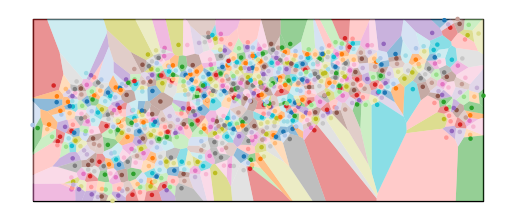

station_ids                                           geometry
0            1  POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
1            2  POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
2            3  POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
3            4  POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
4            5  POLYGON ((-0.15601 51.49509, -0.15846 51.49310...

In [10]:
# get the station locations (geometry points) and convert to an array of coordinates
coords = points_to_coords(stations_with_stats.geometry)

# the voronoi polygons and a dictionary of values mapping each polygon to location index of geodataframe
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

# Plot voronoi regions and station points within specified boundary
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
plt.show()

# create a list to store station ids (unpacking the dictionary mapping polygons to station indices)
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
    vor_polys[ind] = region_polys[i]

# get the station indices from geodataframe
station_ids = stations_with_stats.index.to_list()

# create  a dataframe with station ids and voronoi polygons
vor_df = pd.DataFrame({'station_ids':station_ids, 'geometry':vor_polys})

# create a geodataframe
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')

# display geodataframe
display(vor_gdf.head())

As the stations at the outer edge of the bike scheme vary in distance from the rectangular boundary, their voronoi polygons are unnecessarily large. A better boundary can be created using the shapely's geometry function convex_hull.

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>


/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


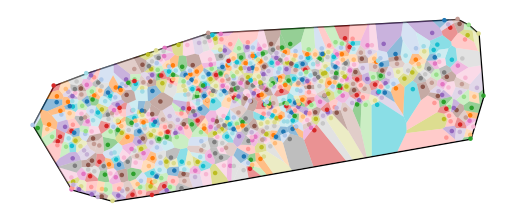

station_ids                                           geometry
0            1  POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
1            2  POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
2            3  POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
3            4  POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
4            5  POLYGON ((-0.15601 51.49509, -0.15846 51.49310...

In [11]:
# Generate a tighter boundary using shapely's inbuilt function convex_hull
convex_hull_polygon = point_collection.convex_hull
print(type(convex_hull_polygon))
convex_hull_polygon = unary_union(convex_hull_polygon)
print(type(convex_hull_polygon))
region_polys, region_pts = voronoi_regions_from_coords(coords, convex_hull_polygon)
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, convex_hull_polygon, region_polys, coords, region_pts)
plt.show()
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
#     display(region_polys[i])
    vor_polys[ind] = region_polys[i]

# Map polygons to original station ids and convert to geodataframe
station_ids = stations_with_stats.index.to_list()
vor_df = pd.DataFrame({'station_ids':station_ids, 'geometry':vor_polys})
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')
display(vor_gdf.head())

This still generates large polygons where the boundary is further away from the stations.
A better boundary around station locations is drawn using the concave hull or alpha shape analysis, as outlined in [Drawing Boundaries in Python](https://thehumangeo.wordpress.com/2014/05/12/drawing-boundaries-in-python/).

In [12]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
 
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
 
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
 
    coords = np.array([point.coords[0] for point in points])
 
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
 
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
 
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
 
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
 
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
 
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
#     return cascaded_union(triangles), edge_points
    return unary_union(triangles), edge_points

Concave hull enclosing station coordinates:


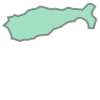

Buffered:


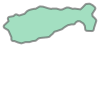

In [13]:
# the alpha value is adjusted to give the best curvature of the concave hull, so that the boundary is fitted to the outer stations
concave_hull, edge_points = alpha_shape(stations_with_stats.geometry, alpha=75)

print("Concave hull enclosing station coordinates:")
display(concave_hull)
print("Buffered:")

# The buffer value draws the boundary further away from the outer stations.
display(concave_hull.buffer(.005))

/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/opt/conda/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


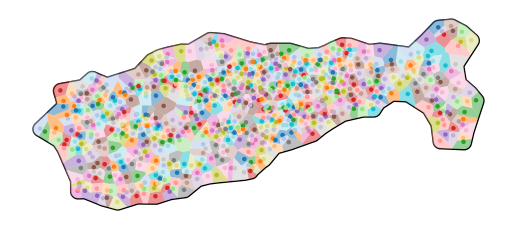

geometry
station_id                                                   
1           POLYGON ((-0.11279 51.53041, -0.11274 51.52936...
2           POLYGON ((-0.19757 51.50282, -0.20028 51.49965...
3           POLYGON ((-0.08416 51.51844, -0.08431 51.51852...
4           POLYGON ((-0.11962 51.52969, -0.12126 51.53236...
5           POLYGON ((-0.15601 51.49509, -0.15846 51.49310...

In [14]:
# Generate a tighter boundary using shapely's inbuilt function convex_hull
# convex_hull_polygon = point_collection.convex_hull
region_polys, region_pts = voronoi_regions_from_coords(coords, concave_hull.buffer(0.004))
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, concave_hull.buffer(0.004), region_polys, coords, region_pts)
plt.show()
vor_polys = [None]*len(region_polys)
for i in range(len(region_polys)):
    ind = region_pts[i][0]
#     display(region_polys[i])
    vor_polys[ind] = region_polys[i]

# Save polyogons and map to station indices
station_ids = stations_with_stats.index.to_list()
vor_df = pd.DataFrame({'station_id':station_ids, 'geometry':vor_polys})

# create geodataframe, setting the projection
vor_gdf = gpd.GeoDataFrame(vor_df,crs=location_crs,geometry='geometry')
vor_gdf.set_index('station_id',inplace=True)
vor_gdf = vor_gdf.sort_index()
display(vor_gdf.head())

The regions and boundary are next plotted with Folium

In [15]:
# Central location on map
# map_centre = [stations.latitude.mean(), stations.longitude.mean()]
map_centre = [stations_with_stats.geometry.y.mean(), stations_with_stats.geometry.x.mean()]
# Create a base map
london_map = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=12
)

# Add ward polygons
folium.GeoJson(vor_gdf.geometry).add_to(london_map)

# Add station markers
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map)
    
london_map

In [16]:
# Merge the voronoi polygon geodataframe with the station location and summary stats geodataframe
# result = pd.merge(stations_with_stats, vor_gdf, on ='station_id')
stations_vor_stats = stations_with_stats.copy()
stations_vor_stats.geometry = vor_gdf.geometry
display(stations_vor_stats.head())

# write to geojson file for plotting as a layer
stations_vor_stats.to_file('voronoi.geojson', driver="GeoJSON") 

# the geojson filepah
# geojson_fpath = '/kaggle/working/voronoi.geojson'

capacity   latitude  longitude  \
station_id                                   
1                 19  51.529163  -0.109970   
2                 37  51.499606  -0.197574   
3                 32  51.521283  -0.084605   
4                 23  51.530059  -0.120973   
5                 27  51.493130  -0.156876   

                                    station_name  \
station_id                                         
1                     River Street , Clerkenwell   
2                 Phillimore Gardens, Kensington   
3           Christopher Street, Liverpool Street   
4                St. Chad's Street, King's Cross   
5                  Sedding Street, Sloane Square   

                                                     geometry  journey_count  \
station_id                                                                     
1           POLYGON ((-0.11279 51.53041, -0.11274 51.52936...           1269   
2           POLYGON ((-0.19757 51.50282, -0.20028 51.49965...           2055   
3           POLYGON ((-0.08416 51.51844, -0.08431 51.51852...           3337   
4           POLYGON ((-0.11962 51.52969, -0.12126 51.53236...           1405   
5           POLYGON ((-0.15601 51.49509, -0.15846 51.49310...           3335   

            daily_journey_count  total_duration_hours  median_duration_mins  \
station_id                                                                    
1                         25.38            338.154444                  11.8   
2                         41.10            712.716667                  13.6   
3                         66.74            834.736944                  11.2   
4                         28.10            456.862500                  13.0   
5                         66.70           1043.140556                  13.2   

            journey_count_per_cap  
station_id                         
1                             1.3  
2                             1.1  
3                             2.1  
4                             1.2  
5                             2.5

The station statistics can be quickly plotted with geopandas geodataframe inbuilt methods

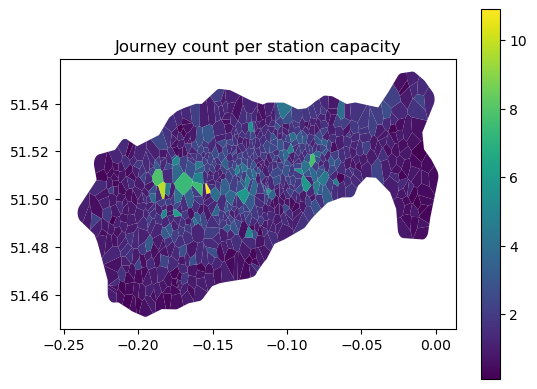

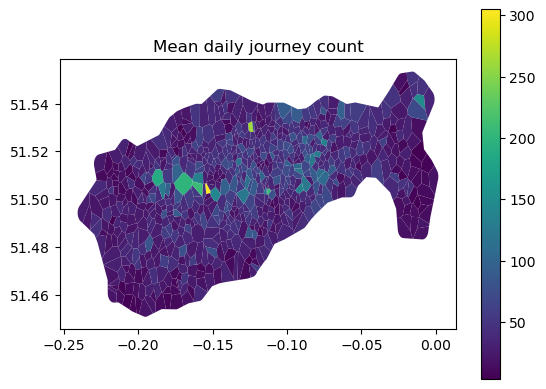

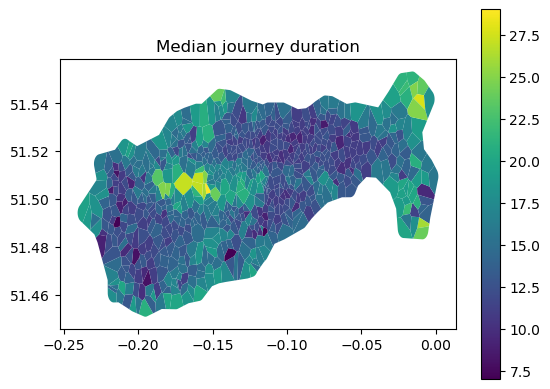

In [17]:
stations_vor_stats.plot(column='journey_count_per_cap', legend = True)
plt.title("Journey count per station capacity")
plt.show()
stations_vor_stats.plot(column='daily_journey_count', legend = True)
plt.title("Mean daily journey count")
plt.show()
stations_vor_stats.plot(column='median_duration_mins', legend = True)
plt.title("Median journey duration")
plt.show()

In [18]:
# Add station_id (currently index) as column
stations_with_stats['station_id'] = stations_with_stats.index.to_list()

## Plot interactive map

Finally plot a map showing station location, station regions, and summary statistics as separate layers

In [19]:
# Create a base map
london_map_v = folium.Map(
    location= map_centre, 
    tiles='cartodbpositron', 
    zoom_start=13
)

# Create a style function to display the bike scheme boundary (concave hull)
boundary_function =lambda x: {'fillColor': '#ffffff', 
                            'color':'blue', 
                            'fillOpacity': 0, 
                            'weight': 2}

# Add boundary to map
folium.GeoJson(concave_hull.buffer(0.004),style_function=boundary_function, name = 'Scheme boundary').add_to(london_map_v)

# Create a style function to display station regions (voronoi polygons)
region_function =lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 0.2}

# Add station regions to map
folium.GeoJson(vor_gdf.geometry,style_function=region_function, name = 'Voronoi regions').add_to(london_map_v)

# Create choropleth with journey count per station capacity
# The quantiles create a custom colour scale
custom_scale = (stations_vor_stats['journey_count_per_cap'].quantile((0,0.25,0.5,0.75,0.9,0.995,1))).tolist()
count_per_cap = folium.Choropleth(
            geo_data=r'/kaggle/working/voronoi.geojson',
            name = 'Journey Count / Station Capacity',
            data = stations_with_stats,
    # journey_count_per_cap
            columns=['station_id','journey_count_per_cap'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.station_id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            threshold_scale=custom_scale, #use the custom scale we created for legend
            fill_color = 'YlOrBr',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=0.4,
            highlight=True,
            edgecolor='black',
            line_color = 'black',
            line_opacity=0.2,
            legend_name='Daily Journeys / Capacity', #title of the legend
)
count_per_cap.add_to(london_map_v)

# Create choropleth with median journey duration summary statistic
# Set a custom colour scale using quantiles
duration_scale = (stations_vor_stats['median_duration_mins'].quantile((0,0.25,0.5,0.75,0.9,0.995,1))).tolist()
# custom_scale = [min(stations_vor_stats['journey_count_per_cap']),100,200,300,400,500,max(stations_vor_stats['journey_count_per_cap'])]
journey_duration = folium.Choropleth(
            geo_data=r'/kaggle/working/voronoi.geojson',
            name = 'Median Journey Duration (mins)',
            data = stations_with_stats,
            columns=['station_id','median_duration_mins'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.station_id', #Here we grab the geometries/county boundaries from the geojson file using the key 'coty_code' which is the same as county fips
            threshold_scale=duration_scale, #use the custom scale we created for legend
            fill_color = 'YlGnBu',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=0.4,
            highlight=True,
            edgecolor='black',
            line_color = 'black',
            line_opacity=0.2,
            legend_name='Journey Duration', #title of the legend
)
journey_duration.add_to(london_map_v)


# hover functionality
# the functions change the way station statistics are displayed on hover over station region
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.5, 
                                'weight': 0.1}
# Use the geojson file to display voronoi regions for each station
NIL = folium.features.GeoJson(
    r'/kaggle/working/voronoi.geojson',
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['station_name', 'capacity', 'daily_journey_count','journey_count_per_cap','median_duration_mins'],  # use fields from the json file
        aliases=['Station Name: ', 'Capacity: ','Daily Journeys: ',"Journeys / Capacity: ",'Median Journey Duration: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
# add layer to map and keep in front
london_map_v.add_child(NIL)
london_map_v.keep_in_front(NIL)

# Add station markers - plot location of each station as circle, where opacity reflects station capacity
for row in stations_with_stats.iterrows():
    row_values = row[1]
    location = [row_values.geometry.y,row_values.geometry.x]
    marker = folium.Circle(location=location, radius = 40, color='black', opacity=0,fill= 'black', fill_opacity = row_values['capacity']/64, popup = row_values['station_name'] + "\n"+"Capacity: "+ str(row_values['capacity']))
    marker.add_to(london_map_v)

#Add layer control to the map
folium.LayerControl(collapsed=False).add_to(london_map_v)
london_map_v.save("index.html") #save to a file

# view map
london_map_v

## Results and conclusion

Toggling map chroropleth players shows that the greatest journey count per station capacity was around Hyde Park, Waterloo and the Strand, and Liverpool Street.
<br>

This suggests that more stations could be added in these areas, or the capacity of existing stations could be increased.
<br>

The longest journeys were started around Hyde Park, Stratford and Canary Warf.
<br>

This confirms that the number of stations or station capacity could be increased around Hyde Park.
<br>

The interactive map with choropleth layers showing summary statistics is a great way to visualise geospatial data, making it easy to see overall patterns.
<br>

## Future work
- The station and journey data could also be plotted by breaking up the bike scheme area into larger voronoi sections and aggregating station data for each region.
- Likewise ward boundaries could be used to plot summary statistics for bike station within each ward.
- Alternatively data could be plotted by postcode.
- Journey stats for weekdays and weekends could be plotted as separate layers.

## REFERENCES

- [Folium and Choropleth Map: From Zero to Pro](https://towardsdatascience.com/folium-and-choropleth-map-from-zero-to-pro-6127f9e68564)

- [Geovoronoi](https://pypi.org/project/geovoronoi/)
- [DRAWING BOUNDARIES IN PYTHON](https://thehumangeo.wordpress.com/2014/05/12/drawing-boundaries-in-python/)

### Further info on Voronoi regions
- [How to create Voronoi regions with Geospatial data in Python](https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134)
- [Create a Python Voronoi Diagram with GeoPandas and Geoplot](https://wellsr.com/python/python-voronoi-diagram-with-geopandas-and-geoplot/)
- [Computing the Voronoi diagram of a set of points](https://ipython-books.github.io/145-computing-the-voronoi-diagram-of-a-set-of-points/)